# Assignment 1
Author: Luis Eduardo "Luise" San Martin

In [10]:
import assignment1
import pandas as pd
import seaborn as sns

## Problem 1: Data Acquisition and Analysis

1. Download reported crime data from Chicago open data portal for 2017 and 2018.

**Answer:**

We've set a function in the assignment1.py file to help with this:

In [3]:
crimes = assignment1.data_on_crimes()
crimes_df = pd.DataFrame.from_dict(crimes)
crimes_df

,arrest,beat,block,case_number,community_area,date,description,district,domestic,fbi_code,...,latitude,location,location_description,longitude,primary_type,updated_on,ward,x_coordinate,y_coordinate,year
0,True,1034,026XX S CALIFORNIA BLVD,JA529032,30,2017-11-28T21:43:00.000,VIOLENT OFFENDER: ANNUAL REGISTRATION,010,False,26,...,41.843778126,"{'type': 'Point', 'coordinates': [-87.69463767...",JAIL / LOCK-UP FACILITY,-87.694637678,OTHER OFFENSE,2018-02-11T15:54:58.000,12,1158280,1886310,2017
1,True,1221,007XX N SACRAMENTO BLVD,JA545986,23,2017-12-11T19:15:00.000,ARMED: HANDGUN,012,False,03,...,41.894475919,"{'type': 'Point', 'coordinates': [-87.70216915...",SIDEWALK,-87.702169158,ROBBERY,2018-02-11T15:54:58.000,27,1156092,1904769,2017
2,False,2222,092XX S RACINE AVE,JB147188,73,2017-10-08T03:00:00.000,NON-AGGRAVATED,022,False,02,...,NaN,NaN,RESIDENCE,NaN,CRIM SEXUAL ASSAULT,2018-02-11T15:57:41.000,21,NaN,NaN,2017
3,False,0835,026XX W 79TH ST,JB147595,70,2017-03-28T14:00:00.000,UNLAWFUL ENTRY,008,False,05,...,NaN,NaN,OTHER,NaN,BURGLARY,2018-02-11T15:57:41.000,18,NaN,NaN,2017
4,False,0313,060XX S EBERHART AVE,JB147230,42,2017-09-09T20:17:00.000,OVER $500,003,False,06,...,NaN,NaN,RESIDENCE,NaN,THEFT,2018-02-11T15:57:41.000,20,NaN,NaN,2017
5,True,0215,003XX E 47TH ST,JA522842,38,2017-11-23T15:14:00.000,AGGRAVATED: HANDGUN,002,False,04A,...,41.809342727,"{'type': 'Point', 'coordinates': [-87.61909899...",DEPARTMENT STORE,-87.619098999,ASSAULT,2018-06-21T15:59:22.000,3,1178967,1873924,2017
6,False,0122,001XX W RANDOLPH ST,JB147599,32,2017-08-26T10:00:00.000,NON-AGGRAVATED,001,False,02,...,NaN,NaN,HOTEL/MOTEL,NaN,CRIM SEXUAL ASSAULT,2018-02-11T15:57:41.000,42,NaN,NaN,2017
7,False,0524,117XX S SANGAMON ST,JB140548,53,2018-02-04T01:36:00.000,FIRST DEGREE MURDER,005,False,01A,...,41.68073915,"{'type': 'Point', 'coordinates': [-87.64566114...",STREET,-87.645661144,HOMICIDE,2019-03-18T16:08:09.000,34,1172100,1827003,2018
8,False,2234,011XX W 111TH ST,JB107989,75,2018-01-07T21:01:00.000,DOMESTIC BATTERY SIMPLE,022,True,08B,...,41.692258729,"{'type': 'Point', 'coordinates': [-87.65053259...",RESIDENCE,-87.65053259,BATTERY,2018-05-04T15:51:04.000,34,1170736,1831190,2018
9,False,1834,004XX N MICHIGAN AVE,JB108319,8,2018-01-05T18:10:00.000,RETAIL THEFT,018,False,06,...,41.890384236,"{'type': 'Point', 'coordinates': [-87.62410991...",DEPARTMENT STORE,-87.624109917,THEFT,2018-05-04T15:51:04.000,42,1177357,1903444,2018


Now `crimes_df` is the dataframe with the crimes data.

2. Generate summary statistics for the crime reports data including but not limited to number of crimes of each type, how they change over time, and how they are different by neighborhood. Please use a combination of tables and graphs to present these summary stats.

**Answer:**

Number of crimes by year:

In [24]:
crimes_df.groupby("year").size()

year
2017    268098
2018    266272
dtype: int64

We can see that the number of crimes reported in 2017 and 2018 was quite similar. The difference between 2018 and 2017 was:

In [25]:
crimes_df.groupby("year").size()[1] - crimes_df.groupby("year").size()[0]

-1826

The percentage change in the number of crimes between 2018 and 2017 was:

In [27]:
round((crimes_df.groupby("year").size()[1] - crimes_df.groupby("year").size()[0])/crimes_df.groupby("year").size()[0] * 100, 1)

-0.7

Number of crimes by type and year:

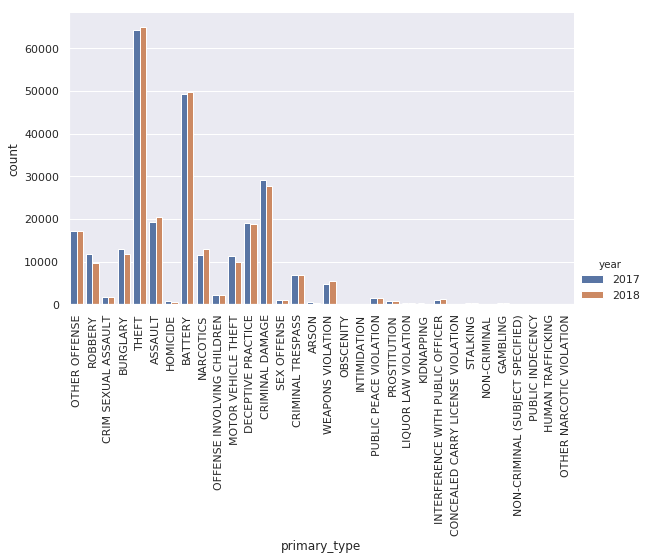

In [44]:
type_year = sns.catplot(x='primary_type', hue='year', kind='count', data=crimes_df, aspect=1.6)
type_year.set_xticklabels(rotation=90)

Both in 2017 and 2018, the most frequent types of crimes registered were theft, battery and criminal damage.

Checking the number of crimes by ward:

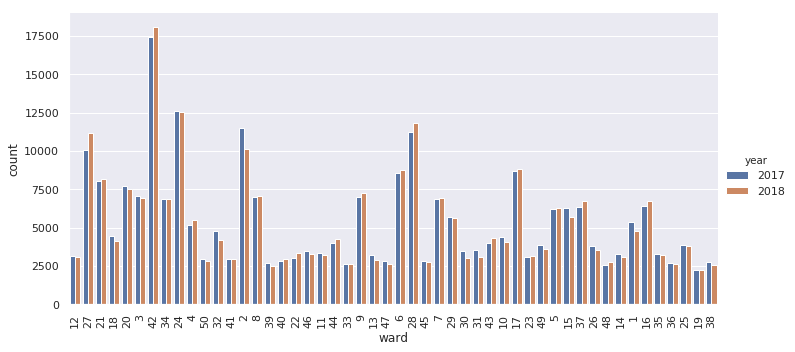

In [52]:
ward_year = sns.catplot(x='ward', hue='year', kind='count', data=crimes_df, aspect=2)
ward_year.set_xticklabels(rotation=90)

The wards with the most number of crimes recorded are wards 42, 24 and 28. Interestingly, some wards seem to present important variations in the number of crimes reported between 2018 and 2017.

Now we'll check which wards have the greatest increases and decreases in reported crimes between 2017 and 2018.

In [73]:
crimes_wards_df = crimes_df.groupby(['ward', 'year']).size().unstack()
crimes_wards_df['variation'] = crimes_wards_df['2018'] - crimes_wards_df['2017']
crimes_wards_df['perc_var'] = crimes_wards_df['variation'] / crimes_wards_df['2017']
crimes_wards_df['ward'] = crimes_wards_df.index

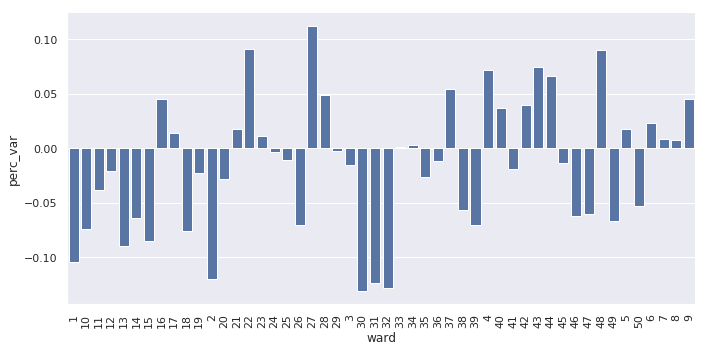

In [72]:
ward_variation_year = sns.catplot(x='ward', y='perc_var', data=crimes_wards_df, aspect=2, kind='bar', color='B')
ward_variation_year.set_xticklabels(rotation=90)